In [152]:
import glob
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split
import matplotlib.pyplot as plt
import yaml
import re
from tokenization import PrettyMidiTokenizer, BCI_TOKENS, SILENCE_TOKEN
from model import TCN
from torcheval.metrics import MulticlassAccuracy

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


# MODEL PARAMETERS
EPOCHS = 500 # 500
LEARNING_RATE = 4 # 4
BATCH_SIZE = 16 # 16
TRAIN_MODEL = True
FEEDBACK = False
EMPHASIZE_EEG = False
EARLY_STOP = True

pwd = os.getcwd()
print(pwd)

DIRECTORY_PATH = ''


cuda:0
/home/marco_bortolotti/project_official/Affective-AI-Music-Improviser/generative_model


In [7]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')

print(DATASET_PATH)

input_filenames = sorted(glob.glob(os.path.join(DATASET_PATH, 'rythms/*.mid')))
print('Number of input files:', len(input_filenames))

output_filenames = sorted(glob.glob(os.path.join(DATASET_PATH, 'melodies/*.mid')))
print('Number of output files:', len(output_filenames), '\n')


INPUT_TOK = PrettyMidiTokenizer()
OUTPUT_TOK = PrettyMidiTokenizer()

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'{i + 1}: {in_file_name} -> {out_file_name}')

    if 'RELAXED' in in_file_name:
        emotion_token = BCI_TOKENS[0]
    elif 'CONCENTRATED' in in_file_name:
        emotion_token = BCI_TOKENS[1]
    else:
        raise Exception('Emotion not found in file name. Please add the emotion to the file name.')

    in_seq, in_df = INPUT_TOK.midi_to_tokens(in_file, update_sequences= True, update_vocab=True, emotion_token = emotion_token, instrument='drum')
    out_seq, out_df = OUTPUT_TOK.midi_to_tokens(out_file, update_sequences= True, update_vocab=True)

    if len(INPUT_TOK.sequences) != len(OUTPUT_TOK.sequences):
        min_len = min(len(INPUT_TOK.sequences), len(OUTPUT_TOK.sequences))
        INPUT_TOK.sequences = INPUT_TOK.sequences[:min_len]
        OUTPUT_TOK.sequences = OUTPUT_TOK.sequences[:min_len]

    print(f'Number of input sequences: {len(in_seq)}')
    print(f'Number of output sequences: {len(out_seq)}')
    print(f'Emotion token: {emotion_token}\n')

print(f'\nNumber of input sequences: {len(INPUT_TOK.sequences)}')
print(f'Input sequence length: {len(INPUT_TOK.sequences[0])}')
print(f'Input vocabulars size: {len(INPUT_TOK.VOCAB)}')
print(f'\nNumber of output sequences: {len(OUTPUT_TOK.sequences)}')
print(f'Output sequence length: {len(OUTPUT_TOK.sequences[0])}')
print(f'Output vocabulars size: {len(OUTPUT_TOK.VOCAB)}')

print('\nInput vocab:', INPUT_TOK.VOCAB.word2idx)
print('Output vocab:', OUTPUT_TOK.VOCAB.word2idx)

# with open('training_seq.txt', 'w') as f:    
#     for seq in INPUT_TOK.sequences:
#         for tok in seq[:48]:
#             f.write('\"' + INPUT_TOK.VOCAB.idx2word[tok] + '\", ')
#         f.write('\n')




dataset
Number of input files: 2
Number of output files: 2 

1: rithm_CONCENTRATED.mid -> melody_CONCENTRATED.mid
Number of input sequences: 1641
Number of output sequences: 1645
Emotion token: C

2: rithm_RELAXED.mid -> melody_RELAXED.mid
Number of input sequences: 1555
Number of output sequences: 1555
Emotion token: R


Number of input sequences: 3196
Input sequence length: 192
Input vocabulars size: 533

Number of output sequences: 3196
Output sequence length: 192
Output vocabulars size: 20997

Input vocab: {'O': 0, 'R': 1, 'C': 2, '36ffS': 3, '38ffS': 4, '42fS': 5, '42ffS': 6, '36ffS_42ffS': 7, '38ppS': 8, '36ppS': 9, '38ffS_42ffS': 10, '38pS': 11, '36ppS_38ppS': 12, '36ffS_38pS': 13, '36pS': 14, '38fS': 15, '38pS_42fS': 16, '36fS': 17, '36ppS_38ffS': 18, '36ffS_49ffS': 19, '36ffS_38pS_42ffS': 20, '38pS_42ffS': 21, '36ffS_38pS_42fS': 22, '38ppS_42ffS': 23, '38pS_38ppS': 24, '36ffS_46ffS': 25, '36ppS_38pS': 26, '36pS_38ffS': 27, '48ffS': 28, '47ppS': 29, '36ffS_38ppS_42fS': 30, '44f

In [8]:
import copy

input_tok_bkp = copy.deepcopy(INPUT_TOK)
output_tok_bkp = copy.deepcopy(OUTPUT_TOK)

In [168]:
# Remove tokens that appear less than # times in the dataset
from tokenization import Dictionary

INPUT_TOK = copy.deepcopy(input_tok_bkp)
OUTPUT_TOK = copy.deepcopy(output_tok_bkp)

for tokenizer in [INPUT_TOK, OUTPUT_TOK]:

    token_frequency_threshold = 0.0001 / 100
    original_vocab = tokenizer.VOCAB
    tokenizer.VOCAB.compute_weights()

    # Remove tokens that appear less than # times in the dataset
    for idx, weigth in enumerate(original_vocab.weights):
        if weigth < token_frequency_threshold:
            original_vocab.counter[idx] = 0

    # Create a new vocab with the updated tokens
    updated_vocab = Dictionary()
    updated_vocab.add_word(SILENCE_TOKEN)
    updated_vocab.add_word(BCI_TOKENS[0])
    updated_vocab.add_word(BCI_TOKENS[1])
    for word in original_vocab.word2idx.keys():
        if original_vocab.counter[original_vocab.word2idx[word]] > 0:
            updated_vocab.add_word(word)

    # Verify that the sequences were updated
    seq = tokenizer.sequences[0][:20].copy()
    seq = [original_vocab.idx2word[tok] for tok in seq]
    print(f'Initial sequence: {seq}')

    # Update the sequences with the new vocab
    for seq in tokenizer.sequences:
        for i, tok in enumerate(seq):
            if original_vocab.counter[tok] == 0 and original_vocab.idx2word[tok] not in BCI_TOKENS.values():
                seq[i] = updated_vocab.word2idx[SILENCE_TOKEN]
                updated_vocab.add_word(SILENCE_TOKEN)
            else:
                word = original_vocab.idx2word[tok]
                seq[i] = updated_vocab.word2idx[word]
                updated_vocab.add_word(word)
    
    tokenizer.VOCAB = updated_vocab
    tokenizer.VOCAB.compute_weights()

    # Verify that the sequences were updated
    seq = tokenizer.sequences[0][:20].copy()
    seq = [tokenizer.VOCAB.idx2word[tok] for tok in seq]
    print(f'Updated sequence: {seq}')

    # Verify that the vocab was updated
    print(f'Inintial number of tokens: {len(original_vocab)}')
    print(f'Final number of tokens: {len(tokenizer.VOCAB)}\n')

Initial sequence: ['C', 'O', 'O', 'O', '36ffS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '38ffS', 'O', 'O', 'O', 'O', 'O', 'O']
Updated sequence: ['C', 'O', 'O', 'O', '36ffS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '38ffS', 'O', 'O', 'O', 'O', 'O', 'O']
Inintial number of tokens: 533
Final number of tokens: 533

Initial sequence: ['O', 'O', 'O', 'O', 'O', '75fS', '75f', '75f', '75f', '75f', 'O', 'O', '74fS', '74f', '74f', '72fS_74f', '72f', '72f', '70fS_72f', '70f']
Updated sequence: ['O', 'O', 'O', 'O', 'O', '75fS', '75f', '75f', '75f', '75f', 'O', 'O', '74fS', '74f', '74f', '72fS_74f', '72f', '72f', '70fS_72f', '70f']
Inintial number of tokens: 20997
Final number of tokens: 20999



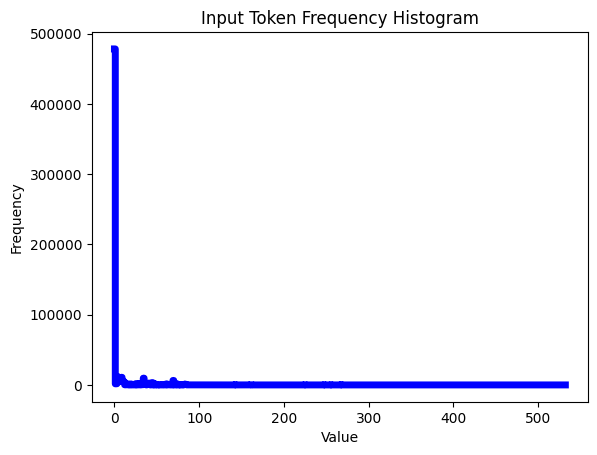

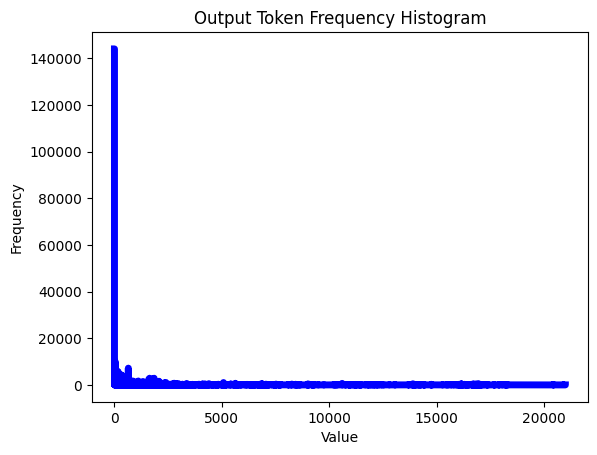

In [169]:
# Plot histogram using plt.step

for tokenizer in [INPUT_TOK, OUTPUT_TOK]:

    if tokenizer == INPUT_TOK:
        title = 'Input'
    else:
        title = 'Output'
  
    bin_edges = np.linspace(0, len(tokenizer.VOCAB.counter), len(tokenizer.VOCAB.counter)+1)
    plt.step(bin_edges[:-1], np.array(tokenizer.VOCAB.counter), where='post', color='blue', linewidth=5)

    # Labeling
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title + ' Token Frequency Histogram')
    plt.show()

In [170]:
# create a dataset
dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),
                        torch.LongTensor(OUTPUT_TOK.sequences).to(device))

# Split the dataset into training, evaluation and test sets
train_set, eval_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

In [171]:
# Augment the training set
def data_augmentation_shift(dataset, shifts):
    '''
    Shifts the sequences by a number of ticks to create new sequences.
    '''
    augmented_input_sequences = []
    output_sequences = []

    for ticks in shifts:
        for input_sequence, ouput_sequence in dataset:
            input_sequence = input_sequence.cpu().numpy().copy()

            # remove the first token since it is the emotion token
            emotion_token = input_sequence[0]
            input_sequence = input_sequence[1:]

            # shift the sequence
            new_input_sequence = np.roll(input_sequence, ticks)

            # add the emotion token back to the sequence
            new_input_sequence = np.concatenate(([emotion_token], new_input_sequence))

            # add the new sequence to the augmented sequences
            augmented_input_sequences.append(new_input_sequence)
            output_sequences.append(ouput_sequence.cpu().numpy().copy())
    
    augmented_dataset = TensorDataset(torch.LongTensor(augmented_input_sequences).to(device), 
                                      torch.LongTensor(output_sequences).to(device))
    
    # Concatenate the original and the augmented dataset
    concatenated_dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

    return concatenated_dataset


def data_augmentation_transposition(dataset, transpositions, probability=0.5):
    '''
    Transpose the sequences by a number of semitones to create new sequences.

    Parameters:
    - transpositions: a list of integers representing the number of semitones to transpose the sequences.

    NB: The transposition is done by adding the number of semitones to the pitch of each note in the sequence.
    '''

    input_sequences = []
    augmented_output_sequences = []

    for transposition in transpositions:
        for input_sequence, ouput_sequence in dataset:

            input_sequence = input_sequence.cpu().numpy().copy()
            new_ouput_sequence = ouput_sequence.cpu().numpy().copy()

            for i in range(len(new_ouput_sequence)):

                token = ouput_sequence[i]
                word = OUTPUT_TOK.VOCAB.idx2word[token]

                # check if the token is a note
                if word != SILENCE_TOKEN and word != BCI_TOKENS['relaxed'] and word != BCI_TOKENS['concentrated']:

                    # extract all the pitches from the token 
                    pitches = re.findall(r'\d+', word) # NB: pitches is a string list

                    # transpose pitch in the token with a probability
                    for pitch in pitches:
                        if np.random.rand() < probability:
                            new_pitch = str(int(pitch) + transposition)
                            word = word.replace(pitch, new_pitch)

                    # add the new token to the vocabulary
                    OUTPUT_TOK.VOCAB.add_word(word) 

                    # update the sequence with the new token
                    new_ouput_sequence[i] = OUTPUT_TOK.VOCAB.word2idx[word]
            
            # update sequence with the new tokens
            input_sequences.append(input_sequence)
            augmented_output_sequences.append(new_ouput_sequence)

    augmented_dataset = TensorDataset(torch.LongTensor(input_sequences).to(device), 
                                      torch.LongTensor(augmented_output_sequences).to(device))
    
    # Concatenate the original and the augmented dataset
    concatenated_dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

    return concatenated_dataset

train_set_augmented = data_augmentation_shift(train_set, [-2, -1, 1, 2])
# train_set_augmented = data_augmentation_transposition(train_set_augmented, [8], probability=0.2)
# train_set_augmented = train_set

print(f'Training set size before augmentation: {len(train_set)}')
print(f'Training set size after augmentation: {len(train_set_augmented)}')

Training set size before augmentation: 2238
Training set size after augmentation: 11190


In [172]:
def initialize_dataset():

  # Create the dataloaders
  train_sampler = RandomSampler(train_set_augmented)
  train_dataloader = DataLoader(train_set_augmented, sampler=train_sampler, batch_size=BATCH_SIZE)

  eval_sampler = RandomSampler(eval_set)
  eval_dataloader = DataLoader(eval_set, sampler=eval_sampler, batch_size=BATCH_SIZE)

  test_sampler = RandomSampler(test_set)
  test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=BATCH_SIZE)

  return train_dataloader, eval_dataloader, test_dataloader

train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()

print(f'Train set size: {len(train_set_augmented)}')
print(f'Evaluation set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')

Train set size: 11190
Evaluation set size: 639
Test set size: 319


In [173]:
# Set the hyperparameters
SEED = 1111
torch.manual_seed(SEED)

'''
IMPORTANT:
to cover all the sequence of tokens k * d must be >= hidden units (see the paper)
k = kernel_size
d = dilation = 2 ^ (n_levels - 1)
'''

OUTPUT_SIZE = len(OUTPUT_TOK.VOCAB)

if FEEDBACK:
    INPUT_SIZE = len(INPUT_TOK.VOCAB) + OUTPUT_SIZE
    LEVELS = 8
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH * 2 # 192 * 2 = 384
else:
    INPUT_SIZE = len(INPUT_TOK.VOCAB)
    LEVELS = 7
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH # 192

print(f'\nInput size: {len(INPUT_TOK.VOCAB)}')


EMBEDDING_SIZE = 20 # size of word embeddings -> Embedding() is used to encode input token into [192, 20] real value vectors (see model.py)
NUM_CHANNELS = [HIDDEN_UNITS] * (LEVELS - 1) + [EMBEDDING_SIZE] # [192, 192, 192, 192, 192, 192, 20]

# balance the loss function by assigning a weight to each token related to its frequency
LOSS_WEIGTHS = torch.ones([OUTPUT_SIZE], dtype=torch.float, device = device)
for i, weigth in enumerate(OUTPUT_TOK.VOCAB.weights):
    LOSS_WEIGTHS[i] = 1 - weigth
    # print(f'{OUTPUT_TOK.VOCAB.idx2word[i]}: {LOSS_WEIGTHS[i]}')
print(f'SILENCE_TOKEN: {LOSS_WEIGTHS[0]}')

def initialize_model():
  # create the model
  model = TCN(input_size = INPUT_SIZE,
              embedding_size = EMBEDDING_SIZE,
              output_size = OUTPUT_SIZE,
              num_channels = NUM_CHANNELS,
              emphasize_eeg = EMPHASIZE_EEG,
              dropout = 0.45,
              emb_dropout = 0.25,
              kernel_size = 3,
              tied_weights = False) # tie encoder and decoder weights (legare)

  model.to(device)

  # May use adaptive softmax to speed up training
  criterion = nn.CrossEntropyLoss(weight = LOSS_WEIGTHS)
  optimizer = getattr(optim, 'Adam')(model.parameters(), lr=LEARNING_RATE)

  return model, criterion, optimizer

model, criterion, optimizer = initialize_model()

print(f'\nModel created: {model}')
print(model.encoder.weight[0])



Input size: 533
SILENCE_TOKEN: 0.773104727268219

Model created: TCN(
  (encoder): Embedding(533, 20)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.45, inplace=False)
        (conv2): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.45, inplace=False)
        (net): Sequential(
          (0): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.45, inplace=False)
          (4): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.45, inplace=False)
        )
        (downsample): Conv1d(20, 192, kernel_size=(1,), stride=(1,))
        (r

/home/marco_bortolotti/miniconda3/envs/virtual_env/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [140]:
def save_parameters():

    # plot the losses over the epochs

    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.legend()
    plt.savefig(os.path.join(RESULTS_PATH, 'losses.png'))
    plt.clf()

    # save the vocabularies
    INPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'input_vocab.txt'))
    OUTPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'output_vocab.txt'))

     # save the model hyperparameters in a file txt
    with open(os.path.join(RESULTS_PATH, 'model_hyperparameters.txt'), 'w') as f:

        f.write(f'DATE: {time.strftime("%Y%m%d-%H%M%S")}\n\n')

        f.write(f'-----------------DATASET------------------\n')
        f.write(f'DATASET_PATH: {DATASET_PATH}\n')
        f.write(f'TRAIN_SET_SIZE: {len(train_set)}\n')
        f.write(f'EVAL_SET_SIZE: {len(eval_set)}\n')
        f.write(f'TEST_SET_SIZE: {len(test_set)}\n\n')


        f.write(f'----------OPTIMIZATION PARAMETERS----------\n')
        f.write(f'GRADIENT_CLIP: {GRADIENT_CLIP}\n')
        f.write(f'FEEDBACK: {FEEDBACK}\n')
        f.write(f'EARLY STOPPING: {EARLY_STOP}\n')
        f.write(f'EMPHASIZE_EEG: {EMPHASIZE_EEG}\n')
        f.write(f'LEARNING_RATE: {LEARNING_RATE}\n')
        f.write(f'BATCH_SIZE: {BATCH_SIZE}\n')
        f.write(f'EPOCHS: {EPOCHS}\n\n')


        f.write(f'------------MODEL PARAMETERS--------------\n')
        f.write(f'SEED: {SEED}\n')
        f.write(f'INPUT_SIZE: {INPUT_SIZE}\n')
        f.write(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}\n')
        f.write(f'LEVELS: {LEVELS}\n')
        f.write(f'HIDDEN_UNITS: {HIDDEN_UNITS}\n')
        f.write(f'NUM_CHANNELS: {NUM_CHANNELS}\n')
        f.write(f'OUTPUT_SIZE: {OUTPUT_SIZE}\n')
        f.write(f'LOSS_WEIGTHS: {LOSS_WEIGTHS}\n\n')



        f.write(f'-------------------RESULTS----------------\n')
        f.write(f'TRAIN_LOSSES: {best_train_loss}\n')
        f.write(f'BEST_EVAL_LOSS: {best_eval_loss}\n')
        f.write(f'TEST_LOSS: {test_loss}\n')
        f.write(f'BEST_TRAIN_ACCURACY: {best_train_accuracy}\n')
        f.write(f'BEST_EVAL_ACCURACY: {best_eval_accuracy}\n')
        f.write(f'TEST_ACCURACY: {test_accuracy}\n')
        f.write(f'BEST_MODEL_EPOCH: {best_model_epoch}\n')

    data = {
        'DATE': time.strftime("%Y%m%d-%H%M%S"),
        'INPUT_SIZE': INPUT_SIZE,
        'EMBEDDING_SIZE': EMBEDDING_SIZE,
        'NUM_CHANNELS': NUM_CHANNELS,
        'OUTPUT_SIZE': OUTPUT_SIZE,
        'KERNEL_SIZE': 3
    }

    path = os.path.join(RESULTS_PATH, 'config.yaml')
    with open(path, 'w') as file:
        yaml.safe_dump(data, file)

In [141]:
BAR_LENGTH = INPUT_TOK.BAR_LENGTH
GRADIENT_CLIP = 0.35
accuracy = MulticlassAccuracy()

def epoch_step(dataloader, mode):

    if FEEDBACK:
        prev_output = torch.zeros([BATCH_SIZE, INPUT_TOK.SEQ_LENGTH], dtype=torch.long, device=device)

    if mode == 'train':
        model.train()
    else:
        model.eval() # disable dropout

    total_loss = 0
    accuracy.reset()

    # iterate over the training data
    for batch_idx, (data, targets) in enumerate(dataloader):

        batch_idx += 1

        # mask the last bar of the input data
        batch_size = data.size(0)
        data_masked = torch.cat((data[:, :BAR_LENGTH*3], torch.ones([batch_size, BAR_LENGTH], dtype=torch.long, device = device)), dim = 1)

        if FEEDBACK:
            input = torch.cat((data_masked, prev_output[:batch_size, :]), dim = 1)
        else:
            input = data_masked

        # reset model gradients to zero
        optimizer.zero_grad()

        # make the prediction
        output = model(input)[:, :INPUT_TOK.SEQ_LENGTH]
        prev_output = torch.argmax(output, 2)# batch, seq_len (hidden units), vocab_size

        # flatten the output sequence
        # NB: the size -1 is inferred from other dimensions
        # NB: contiguous() is used to make sure the tensor is stored in a contiguous chunk of memory, necessary for view() to work

        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, OUTPUT_SIZE)

        accuracy.update(final_output, final_target)

        # calculate the loss
        loss = criterion(final_output, final_target)

        if mode == 'train':
            # calculate the gradients
            loss.backward()

            # clip the gradients to avoid exploding gradients
            if GRADIENT_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

            # update the weights
            optimizer.step()

        total_loss += loss.data.item()

    return total_loss / len(dataloader), accuracy.compute()


In [155]:
def train(results_path = None):

    global RESULTS_PATH, MODEL_PATH
    global best_eval_loss, best_train_loss, best_model_epoch, train_losses, eval_losses
    global best_train_accuracy, best_eval_accuracy

    if results_path is None:
        RESULTS_PATH = os.path.join('results', time.strftime("%Y%m%d_%H%M%S"))
    else:
        RESULTS_PATH = results_path
    
    if not os.path.exists(RESULTS_PATH):
        os.makedirs(RESULTS_PATH)

    MODEL_PATH = os.path.join(RESULTS_PATH, 'model_state_dict.pth')

    best_eval_loss = 1e8
    best_train_loss = 1e8
    best_eval_accuracy = 0
    best_train_accuracy = 0
    best_model_epoch = 0
    eval_losses = []
    train_losses = []
    lr = LEARNING_RATE

    writer = SummaryWriter()

    for epoch in range(1, EPOCHS+1):

        start_time = time.time()

        train_loss, train_accuracy = epoch_step(train_dataloader, 'train')
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)

        eval_loss, eval_accuracy = epoch_step(eval_dataloader, 'eval')
        writer.add_scalar('Loss/eval', eval_loss, epoch)
        writer.add_scalar('Accuracy/eval', eval_accuracy, epoch)

        # Save the model if the validation loss is the best we've seen so far.
        if eval_loss < best_eval_loss:
            # torch.save(model.state_dict(), MODEL_PATH)
            best_eval_loss = eval_loss
            best_model_epoch = epoch

        if train_loss < best_train_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_train_loss = train_loss

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
        
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy

        # Anneal the learning rate if the validation loss plateaus
        if epoch > 5 and eval_loss >= max(train_losses[-5:]):
            lr = lr / 2.
            if lr < 0.000001:
                lr = LEARNING_RATE
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


        eval_losses.append(eval_loss)
        train_losses.append(train_loss)

        # Early stopping
        if EARLY_STOP:
          if epoch > 15:
              if min(train_losses[-15:]) > best_train_loss:
                  break

        # print the loss and the progress
        elapsed = time.time() - start_time
        print('| epoch {:3d}/{:3d} | lr {:02.5f} | ms/epoch {:5.5f} | train_acc {:5.2f} | train_loss {:5.2f}' \
                .format(epoch, EPOCHS, lr, elapsed * 1000, train_accuracy, train_loss))


    print('\n\n TRAINING FINISHED:\n\n\tBest Loss: {:5.2f}\tBest Model saved at epoch: {:3d} \n\n' \
            .format(best_eval_loss, best_model_epoch))


    # test the model
    global test_loss, test_accuracy
    test_loss, test_accuracy = epoch_step(test_dataloader, 'eval')
    print(f'\n\nTEST LOSS: {test_loss}')
    print(f'TEST ACCURACY: {test_accuracy}')

    save_parameters()

    writer.flush()
    writer.close()
    

In [174]:
# MODEL PARAMETERS
TRAIN_MODEL = True

EPOCHS = 1000 # 500
LEARNING_RATE = 0.002 # 4
BATCH_SIZE = 32 # 16
EARLY_STOP = True

train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()

FEEDBACK = False
EMPHASIZE_EEG = False
model, criterion, optimizer = initialize_model()
train('results/model2')


/home/marco_bortolotti/miniconda3/envs/virtual_env/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


| epoch   1/1000 | lr 0.00200 | ms/epoch 125360.34870 | train_acc  0.23 | train_loss  7.06
| epoch   2/1000 | lr 0.00200 | ms/epoch 124555.51696 | train_acc  0.24 | train_loss  6.69
| epoch   3/1000 | lr 0.00200 | ms/epoch 125856.33183 | train_acc  0.24 | train_loss  6.47


KeyboardInterrupt: 

In [ ]:

# FEEDBACK = False
# EMPHASIZE_EEG = True
# model, criterion, optimizer = initialize_model()
# train('results/LR2/model_EEG')

# FEEDBACK = True
# EMPHASIZE_EEG = False
# model, criterion, optimizer = initialize_model()
# train('results/model_feedback')

# FEEDBACK = True
# EMPHASIZE_EEG = True
# model, criterion, optimizer = initialize_model()
# train('results/model_EEG_feedback')

# if TRAIN_MODEL:

#   for i in range(2):

#     if i == 0:
#       FEEDBACK = False
#     else:
#       FEEDBACK = True

#     BATCH_SIZE = 4
#     LEARNING_RATE = 1.0
#     model, criterion, optimizer = initialize_model()
#     train()

#     LEARNING_RATE = 2.0
#     model, criterion, optimizer = initialize_model()
#     train()

#     LEARNING_RATE = 4.0
#     model, criterion, optimizer = initialize_model()
#     train()

#     LEARNING_RATE = 1.0
#     BATCH_SIZE = 8
#     train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
#     model, criterion, optimizer = initialize_model()
#     train()

#     BATCH_SIZE = 16
#     train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
#     model, criterion, optimizer = initialize_model()
#     train()

#     BATCH_SIZE = 32
#     train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
#     model, criterion, optimizer = initialize_model()
#     train()